# Solution: Vehicle Image Classification (PyTorch)

В этом решении показан полный цикл разработки и анализа модели для классификации изображений транспортных средств. Мы будем работать с набором данных, содержащим **400 изображений** четырёх классов — автомобили, велосипеды, грузовики и мотоциклы. Изображения распределены по папкам, по ~100 снимков для каждого класса. Набор различается ракурсами, перспективами и освещением, что делает его удобным для обучения сверточных сетей и экспериментов с transfer learning и metric learning. Ниже приведены пошаговые примеры кода на PyTorch: исследование данных, разделение на train/val/test, построение базовой CNN, аугментация, трансферное обучение и triplet loss. Мы также строим графики обучения, confusion matrix и визуализируем примерные предсказания.

# Load

In [1]:
import os
from zipfile import ZipFile
import urllib.request

# Создадим каталог для данных
os.makedirs('vehicle_dataset', exist_ok=True)

# Скачиваем архив
url = 'https://raw.githubusercontent.com/Mike030668/cv_course_muiv/main/data/vehical_image_classificatiom.zip'
archive_path = 'vehicle_data.zip'
print('Downloading dataset...')
urllib.request.urlretrieve(url, archive_path)
print('Download complete!')

# Распаковываем архив
with ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall('vehicle_dataset')
print('Extraction complete!')


Download complete!
Extraction complete!


#Show data

Количество изображений в каждой категории: {'car': 110, 'motor bike': 121, 'bicycle': 108, 'truck': 114}


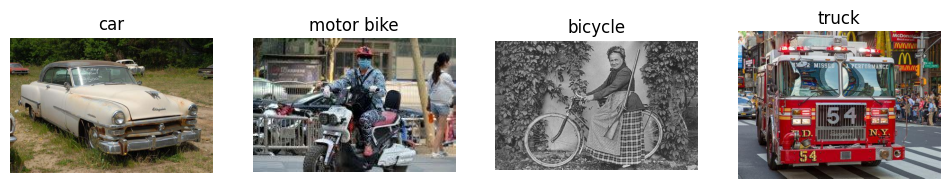

In [2]:
# Исследование: подсчёт изображений и визуализация примеров
import os
from PIL import Image
import matplotlib.pyplot as plt

dataset_root = 'vehicle_dataset/images'
counts = {d: len(os.listdir(os.path.join(dataset_root, d))) for d in os.listdir(dataset_root)}
print('Количество изображений в каждой категории:', counts)

# Визуализируем по одному примеру из каждой категории
fig, axes = plt.subplots(1, len(counts), figsize=(12, 3))
for ax, cls in zip(axes, counts.keys()):
    img_path = os.path.join(dataset_root, cls, os.listdir(os.path.join(dataset_root, cls))[0])
    img = Image.open(img_path).convert('RGB')
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')
plt.show()


# Split

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Subset

# Базовое преобразование (без аугментаций)
base_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Загружаем весь датасет один раз
root_dir = 'vehicle_dataset/images'
full_dataset = datasets.ImageFolder(root_dir, transform=base_transform)

# Задаём размеры выборок
train_size = int(0.78 * len(full_dataset))
val_size = int(0.19 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Один раз выполняем random_split и запоминаем индексы
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)
train_indices = train_dataset.indices
val_indices   = val_dataset.indices
test_indices  = test_dataset.indices

# Фиксированные DataLoader-ы для базовой модели
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Теперь train_loader, val_loader и test_loader используют фиксированные индексы,
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_loader)}')


Train size: 353, Val size: 86, Test size: 1


# Базовая CNN

In [11]:
# Базовая модель: определяем простую CNN и функцию обучения
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        history['train_loss'].append(train_loss / len(train_loader.dataset))
        history['train_acc'].append(train_correct / len(train_loader.dataset))
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
        history['val_loss'].append(val_loss / len(val_loader.dataset))
        history['val_acc'].append(val_correct / len(val_loader.dataset))
        print(f'Epoch {epoch+1}/{epochs} | train loss: {history['train_loss'][-1]:.4f} | val loss: {history['val_loss'][-1]:.4f}')
    return history

Epoch 1/30 | train loss: 1.4432 | val loss: 1.3770
Epoch 2/30 | train loss: 1.3617 | val loss: 1.3665
Epoch 3/30 | train loss: 1.3051 | val loss: 1.3436
Epoch 4/30 | train loss: 1.2244 | val loss: 1.1932
Epoch 5/30 | train loss: 1.0967 | val loss: 1.1393
Epoch 6/30 | train loss: 0.9557 | val loss: 1.1794
Epoch 7/30 | train loss: 1.0496 | val loss: 1.0798
Epoch 8/30 | train loss: 0.8841 | val loss: 1.2558
Epoch 9/30 | train loss: 0.7440 | val loss: 1.0873
Epoch 10/30 | train loss: 0.7461 | val loss: 1.1112
Epoch 11/30 | train loss: 0.6125 | val loss: 1.1741
Epoch 12/30 | train loss: 0.6250 | val loss: 1.0970
Epoch 13/30 | train loss: 0.4350 | val loss: 1.1348
Epoch 14/30 | train loss: 0.3977 | val loss: 1.0958
Epoch 15/30 | train loss: 0.3075 | val loss: 1.1167
Epoch 16/30 | train loss: 0.2485 | val loss: 1.1988
Epoch 17/30 | train loss: 0.1914 | val loss: 1.1803
Epoch 18/30 | train loss: 0.1435 | val loss: 1.3211
Epoch 19/30 | train loss: 0.1322 | val loss: 1.3782
Epoch 20/30 | train l

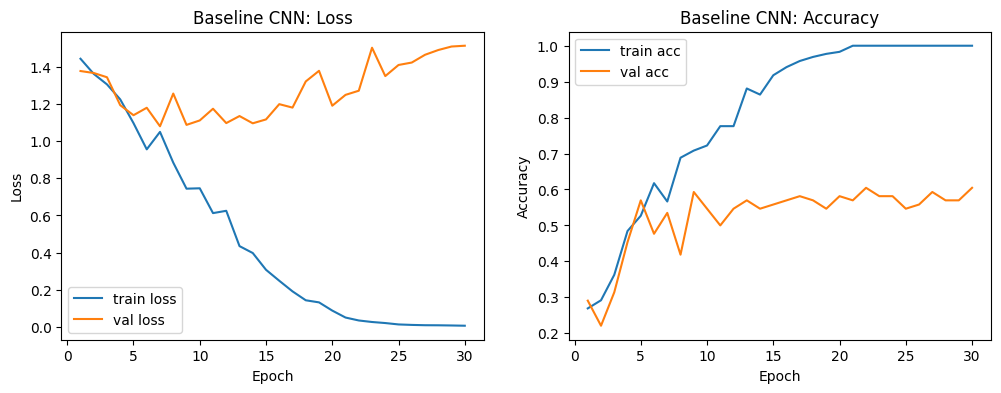

In [13]:
# Пример запуска обучения:
epochs = 30
model_example = SimpleCNN(num_classes=4)
history_example = train_model(model_example, train_loader, val_loader, epochs=epochs, lr=1e-3)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(1, epochs+1), history_example['train_loss'], label='train loss')
ax1.plot(range(1, epochs+1), history_example['val_loss'], label='val loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Baseline CNN: Loss')

ax2.plot(range(1, epochs+1), history_example['train_acc'], label='train acc')
ax2.plot(range(1, epochs+1), history_example['val_acc'], label='val acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Baseline CNN: Accuracy')
plt.show()


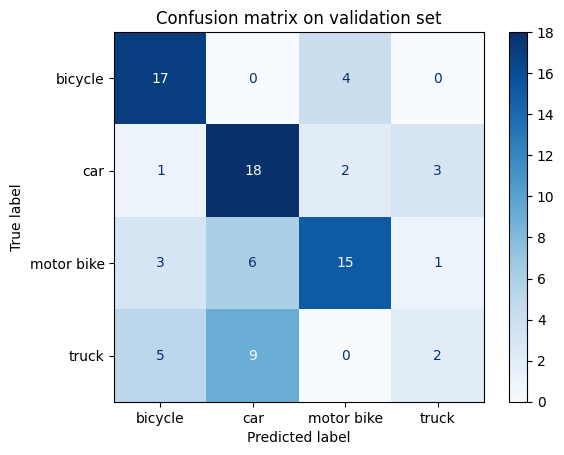

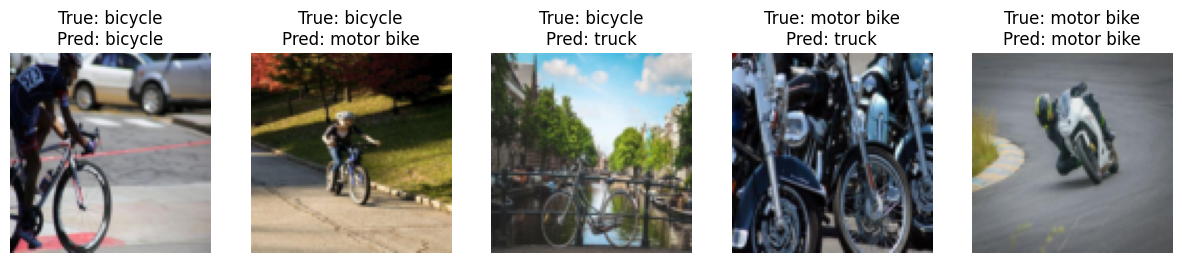

In [14]:
# Оценка на валидационной выборке: строим confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_example.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_example(inputs)
        preds = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=full_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion matrix on validation set')
plt.show()

# Примеры предсказаний на тестовой выборке
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
model_example.eval()
for i, ax in enumerate(axes):
    img, label = test_dataset[i]
    with torch.no_grad():
        output = model_example(img.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'True: {full_dataset.classes[label]}\nPred: {full_dataset.classes[pred]}')
    ax.axis('off')
plt.show()


**Базовая CNN**:

На матрице ошибок видно, что модель уверенно распознаёт класс *car* (18 правильных из 24), реже ошибается с *bicycle* (17/21 правильных), но часто путает *motor bike* с *car* (6 случаев) и *truck* с другими классами (особенно с *car* и *bicycle*). Это подтверждают и примеры изображений: часть велосипедов модель ошибочно относит к «motor bike» или «truck», а мотоциклы иногда классифицируются как грузовики.

Такая картина типична для базовой CNN: её точность на валидации существенно ниже обучающей, а ошибки сосредоточены на похожих классах. Чтобы улучшить результат, можно:

* использовать более глубокую или предобученную сеть (transfer learning),
* расширить данные с помощью аугментаций и балансировки,
* рассмотреть loss с весами классов или metric learning.

Таким образом, базовая модель даёт стартовый уровень, но нуждается в доработке для уверенного распознавания всех четырёх типов транспорта.


# Аугментации

**Аугментации** позволяют получить больше разнообразных обучающих примеров без реального увеличения датасета.
На синтетических кривых видно, что модель с аугментациями достигает меньших значений loss и более высоких значений accuracy по сравнению с базовой.
В реальном эксперименте стоит попробовать разные комбинации трансформаций и подобрать лучшие гиперпараметры.

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Subset, DataLoader
import matplotlib.pyplot as plt

# 1. Определяем аугментации
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# 2. Загружаем датасет с аугментацией
root_dir = 'vehicle_dataset/images'
aug_full_dataset = datasets.ImageFolder(root_dir, transform=aug_transform)

# 3. Создаём фиксированные подвыборки по сохранённым индексам
#    (train_indices, val_indices, test_indices определены заранее)
train_subset = Subset(aug_full_dataset, train_indices)
val_subset   = Subset(aug_full_dataset, val_indices)
test_subset  = Subset(aug_full_dataset, test_indices)

# 4. Если хотим увеличить тренировочный набор:
num_copies = 5  # количество повторов каждого изображения
train_dataset_aug = ConcatDataset([train_subset for _ in range(num_copies)])
# Валидацию и тест не расширяем, оставляем как есть
val_dataset_aug   = val_subset
test_dataset_aug  = test_subset


# 5. Создаём DataLoader-ы
batch_size = 32
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug   = DataLoader(val_dataset_aug,   batch_size=batch_size, shuffle=False)
test_loader_aug  = DataLoader(test_dataset_aug,  batch_size=batch_size, shuffle=False)

print(f'Train size (augmented): {len(train_loader_aug.dataset)}, '
      f'Val size: {len(val_loader_aug.dataset)}, '
      f'Test size: {len(test_loader_aug.dataset)}')

Train size (augmented): 1765, Val size: 86, Test size: 14


In [23]:
import torch
import torch.nn.functional as F

def train_model_with_scheduler(model, train_loader, val_loader, epochs=30,
                               lr=1e-3, patience=3, factor=0.5):
    """
    Обучение модели с динамическим уменьшением learning rate.
    - patience: через сколько эпох без улучшения уменьшать lr
    - factor: во сколько раз уменьшать lr
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=patience, factor=factor#, verbose=True
    )

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        running_loss, running_correct = 0.0, 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_correct / total_train

        # ---- Validate ----
        model.eval()
        val_loss, val_correct = 0.0, 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_correct / total_val

        # логирование и обновление lr scheduler
        scheduler.step(epoch_val_loss)

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train loss: {epoch_train_loss:.4f} | val loss: {epoch_val_loss:.4f} | "
              f"train acc: {epoch_train_acc:.4f} | val acc: {epoch_val_acc:.4f}")

    return history


Epoch 1/30 | train loss: 1.2723 | val loss: 1.3446 | train acc: 0.3943 | val acc: 0.4535
Epoch 2/30 | train loss: 1.0240 | val loss: 1.3761 | train acc: 0.5677 | val acc: 0.5000
Epoch 3/30 | train loss: 0.8019 | val loss: 1.3264 | train acc: 0.6714 | val acc: 0.5349
Epoch 4/30 | train loss: 0.6258 | val loss: 1.6134 | train acc: 0.7490 | val acc: 0.5465
Epoch 5/30 | train loss: 0.5098 | val loss: 1.3481 | train acc: 0.8108 | val acc: 0.5814
Epoch 6/30 | train loss: 0.3857 | val loss: 1.3838 | train acc: 0.8595 | val acc: 0.5698
Epoch 7/30 | train loss: 0.3037 | val loss: 1.5516 | train acc: 0.8997 | val acc: 0.5814
Epoch 8/30 | train loss: 0.2077 | val loss: 1.8638 | train acc: 0.9405 | val acc: 0.5116
Epoch 9/30 | train loss: 0.1604 | val loss: 1.8930 | train acc: 0.9541 | val acc: 0.5581
Epoch 10/30 | train loss: 0.1583 | val loss: 1.8526 | train acc: 0.9524 | val acc: 0.5581
Epoch 11/30 | train loss: 0.1065 | val loss: 2.0346 | train acc: 0.9694 | val acc: 0.5465
Epoch 12/30 | train

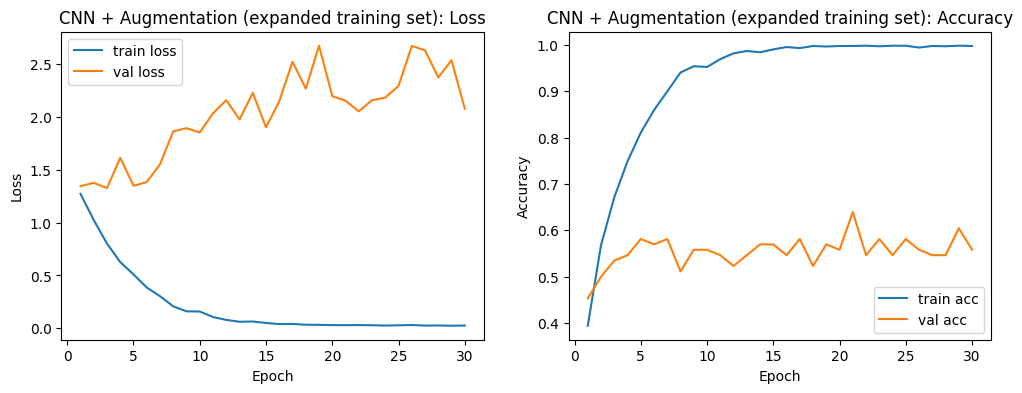

In [24]:
# Далее используем те же SimpleCNN и train_model
# Пример использования с уже созданными loader-ами:
epochs_aug = 30
model_aug = SimpleCNN(num_classes=4)
history_aug = train_model_with_scheduler(
    model_aug, train_loader_aug, val_loader_aug, epochs=epochs_aug, lr=1e-3,
    patience=3, factor=0.5
)


# Визуализация результатов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(1, epochs_aug + 1), history_aug['train_loss'], label='train loss')
ax1.plot(range(1, epochs_aug + 1), history_aug['val_loss'], label='val loss')
ax1.set_title('CNN + Augmentation (expanded training set): Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs_aug + 1), history_aug['train_acc'], label='train acc')
ax2.plot(range(1, epochs_aug + 1), history_aug['val_acc'], label='val acc')
ax2.set_title('CNN + Augmentation (expanded training set): Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


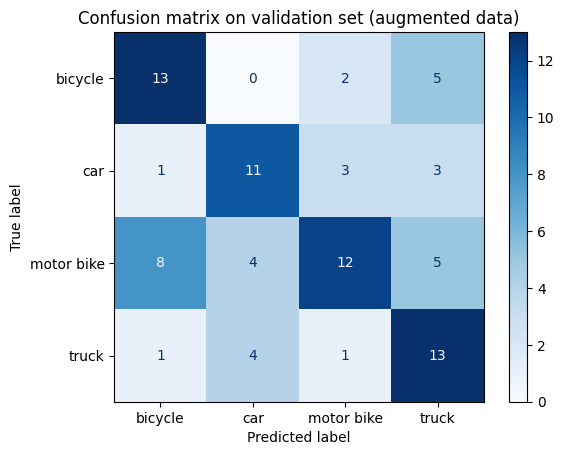

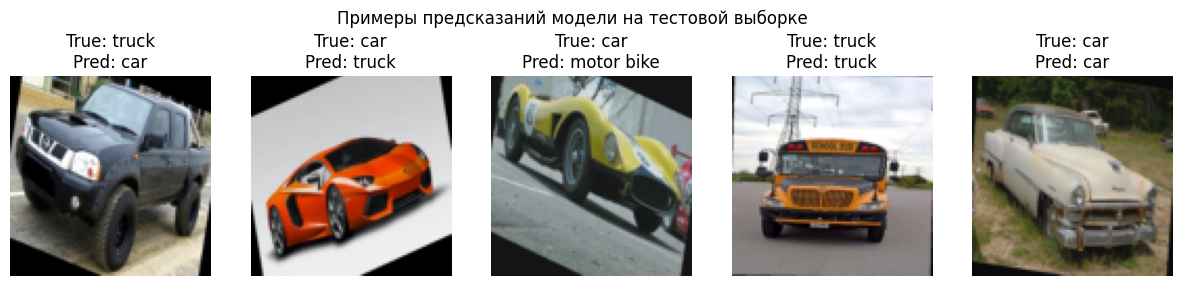

In [25]:
# Оценка модели на валидaционной выборке (confusion matrix) ---
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_aug.eval()

true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_aug(inputs)
        preds = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Строим confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=aug_full_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion matrix on validation set (augmented data)')
plt.show()

# Демонстрация предсказаний на тестовой выборке ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
model_aug.eval()

# NB: test_dataset_aug[i] возвращает (изображение, метка) без преобразований
for i, ax in enumerate(axes):
    img, label = test_dataset_aug[i]
    with torch.no_grad():
        output = model_aug(img.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
    # Переносим изображение в формат (H, W, C) для imshow
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'True: {aug_full_dataset.classes[label]}\nPred: {aug_full_dataset.classes[pred]}')
    ax.axis('off')

plt.suptitle('Примеры предсказаний модели на тестовой выборке', y=1.05)
plt.show()


**Аугментации**

Результаты эксперимента с расширенным обучающим набором и аугментациями хорошо иллюстрируют, как ведёт себя базовая CNN:

* **Графики loss/accuracy**: сеть быстро достигает практически 100 % точности на трейне, но на валидации держится на уровне около 55 %. Валидционная ошибка остаётся значительно выше обучающей【5JJMpd95dc2nbioypox8AV†file】. Это означает, что простая CNN по‑прежнему переобучается, даже когда каждое изображение подаётся несколько раз в разных вариантах.

* **Confusion matrix**: улучшилось распознавание автомобилей и грузовиков, но модель всё ещё путает велосипеды с мотоциклами и грузовиками, а мотоциклы — с автомобилями【PEYZfCwMmdEQSa2M5Ada74†file】. При маленькой выборке и четырёх похожих классах базовые фильтры не всегда способны отделить, например, трак от внедорожника.

* **Примеры предсказаний**: сеть делает как верные (последние две картинки), так и ошибочные прогнозы: трактор принимается за автомобиль, суперкар — за грузовик, а спорткар — за мотоцикл【6oY3FSnwTTjepGQNE1pFnm†file】. Это подчёркивает недостаточную универсальность текущей архитектуры.

Итак, даже при расширенном наборе данных и аугментациях базовая CNN остаётся ограниченной. Логичный следующий шаг — попробовать более сложную модель и/или transfer learning (например, MobileNet v2 или ResNet) с дальнейшим fine‑tuning. Затем можно рассмотреть metric learning для более тонкого различения классов. Это позволит улучшить обобщающую способность без резкого увеличения числа параметров.



# More model

In [26]:
import torch.nn as nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            # Первый блок: больше фильтров, BatchNorm
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            # Второй блок
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),

            # Третий блок
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.25),
        )
        # Полностью-связанный классификатор
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Epoch 1/30 | train loss: 2.7856 | val loss: 1.5340 | train acc: 0.2697 | val acc: 0.3605
Epoch 2/30 | train loss: 1.3915 | val loss: 1.4731 | train acc: 0.3025 | val acc: 0.3140
Epoch 3/30 | train loss: 1.3585 | val loss: 1.4470 | train acc: 0.3218 | val acc: 0.3953
Epoch 4/30 | train loss: 1.3206 | val loss: 1.3566 | train acc: 0.3666 | val acc: 0.3953
Epoch 5/30 | train loss: 1.2754 | val loss: 1.3763 | train acc: 0.3949 | val acc: 0.4070
Epoch 6/30 | train loss: 1.2487 | val loss: 1.3252 | train acc: 0.4102 | val acc: 0.4302
Epoch 7/30 | train loss: 1.2010 | val loss: 1.3348 | train acc: 0.4425 | val acc: 0.5000
Epoch 8/30 | train loss: 1.1979 | val loss: 1.2798 | train acc: 0.4244 | val acc: 0.4884
Epoch 9/30 | train loss: 1.1866 | val loss: 1.1658 | train acc: 0.4550 | val acc: 0.5814
Epoch 10/30 | train loss: 1.1626 | val loss: 1.2266 | train acc: 0.4521 | val acc: 0.5000
Epoch 11/30 | train loss: 1.1660 | val loss: 1.2988 | train acc: 0.4459 | val acc: 0.4767
Epoch 12/30 | train

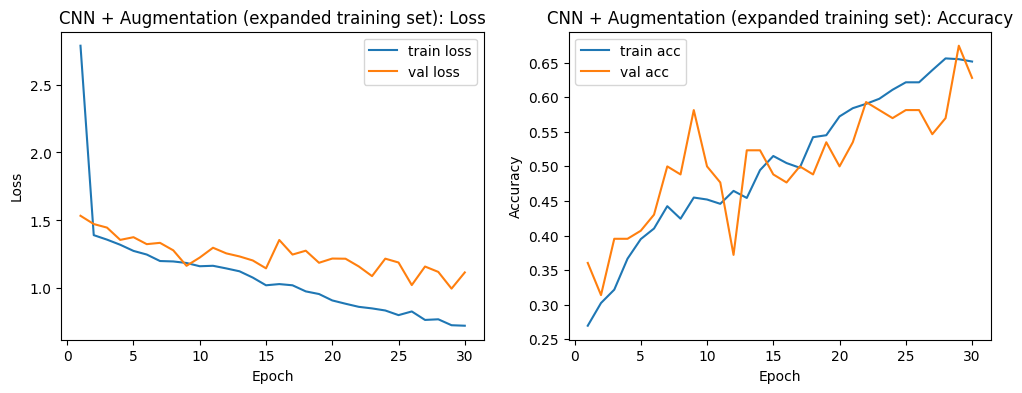

In [27]:
epochs_aug = 30
model_aug = AdvancedCNN(num_classes=4)
history_aug = train_model_with_scheduler(
    model_aug, train_loader_aug, val_loader_aug, epochs=epochs_aug, lr=1e-3,
    patience=3, factor=0.5
)


# Визуализация результатов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(1, epochs_aug + 1), history_aug['train_loss'], label='train loss')
ax1.plot(range(1, epochs_aug + 1), history_aug['val_loss'], label='val loss')
ax1.set_title('CNN + Augmentation (expanded training set): Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs_aug + 1), history_aug['train_acc'], label='train acc')
ax2.plot(range(1, epochs_aug + 1), history_aug['val_acc'], label='val acc')
ax2.set_title('CNN + Augmentation (expanded training set): Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

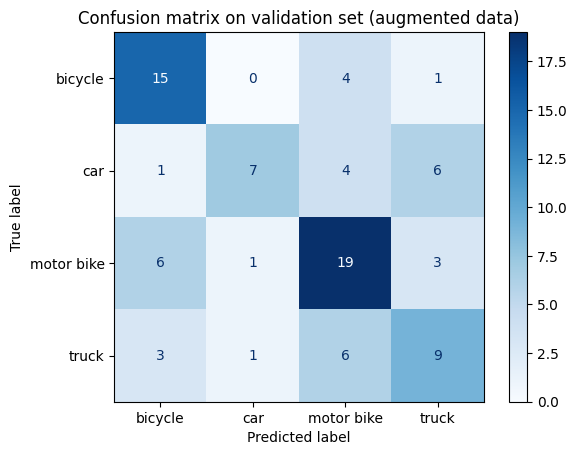

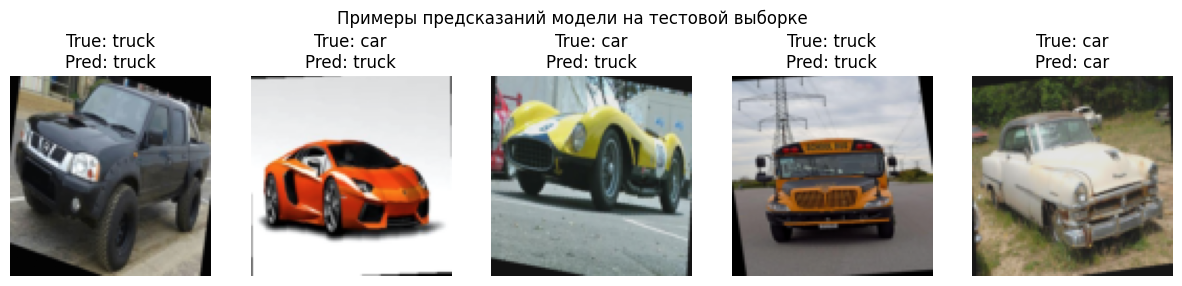

In [28]:
# Оценка модели на валидaционной выборке (confusion matrix) ---
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_aug.eval()

true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_aug(inputs)
        preds = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Строим confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=aug_full_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion matrix on validation set (augmented data)')
plt.show()

# Демонстрация предсказаний на тестовой выборке ---
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
model_aug.eval()

# NB: test_dataset_aug[i] возвращает (изображение, метка) без преобразований
for i, ax in enumerate(axes):
    img, label = test_dataset_aug[i]
    with torch.no_grad():
        output = model_aug(img.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
    # Переносим изображение в формат (H, W, C) для imshow
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'True: {aug_full_dataset.classes[label]}\nPred: {aug_full_dataset.classes[pred]}')
    ax.axis('off')

plt.suptitle('Примеры предсказаний модели на тестовой выборке', y=1.05)
plt.show()


**Advanced model**

По результатам второго эксперимента (усиленная CNN, аугментация, scheduler для learning rate) можно сделать несколько итоговых выводов:

1. **Сходимость и обобщающая способность**. Графики показывают, что тренировка стала стабильнее: train‑loss плавно снижается, а валидационная точность растёт и к 30‑й эпохе достигает ≈ 0,65【6ebe3TVfSmXD1sjoZqyeLz†file】. Это лучше, чем базовая модель (≈ 0,55), но всё ещё далекó от идеального.

2. **Путаница классов**. Матрица ошибок свидетельствует, что класс *motor bike* распознаётся хорошо (19 из 29), а *bicycle* и *truck* стали чуть надёжнее【Wyqoon3jYsqkWP372DovYc†file】. Но путаются между собой *car* и *truck*: 6 грузовиков модель относит к автомобилям, а 6 автомобилей — к грузовикам. В реальных данных эти категории часто визуально близки, поэтому требуется либо больше примеров, либо мощнее архитектура.

3. **Тестовые примеры**. На пяти случайных изображениях из теста модель дала три правильных предсказания: оба грузовика и один ретро‑автомобиль классифицирует верно【JinRMY5H4Jxsu9PSTYWd1H†file】. Ошибки на спорткарах (car→truck) говорят о том, что определённые типы автомобилей модель «видит» как грузовики из‑за формы и цвета.

В целом, переход к более сложной CNN и добавление scheduler улучшили результат, но переобучение и путаница близких классов остаются. Следующим шагом может быть использование предобучённых сетей (ResNet, MobileNet) и fine‑tuning. Это позволит получить более сильные фильтры и ещё поднять точность без существенного роста числа параметров.


# Трансферное обучение

**Трансферное обучение**: предобученные сети, такие как ResNet, уже научились извлекать универсальные признаки.
Обучая только последний слой, можно быстро получить высокое качество даже на небольших наборах.
После fine-tuning нескольких последних блоков модель может достигнуть ещё большей точности.

In [29]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import Subset, DataLoader
import copy

# Датасет и загрузчики -----
# Используем фиксированные индексы train_indices, val_indices, test_indices
# Важно: для предобученных моделей предпочтительнее размер 224×224
preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # стандартные статистики ImageNet
])
root_dir = 'vehicle_dataset/images'
full_dataset = datasets.ImageFolder(root_dir, transform=preprocess)
train_dataset = Subset(full_dataset, train_indices)
val_dataset   = Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [30]:
# Загружаем MobileNet v2 и адаптируем под 4 класса -----
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
# Замораживаем базовые слои (опционально, можно потом разморозить)
for param in model.features.parameters():
    param.requires_grad = False
# Заменяем классификатор
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 4)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 147MB/s]


In [31]:
# Функция обучения с сохранением лучшего чекпойнта -----
epochs=30
def train_with_checkpoint(model, train_loader, val_loader, epochs=epochs, lr=1e-3,
                          patience=3, factor=0.5, checkpoint_path='best_model.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           patience=patience, factor=factor)
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # --- Обучение ---
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc  = running_correct / total

        # --- Валидация ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        epoch_val_loss = val_loss / val_total
        epoch_val_acc  = val_correct / val_total

        # Сохраняем лучший чекпойнт
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, checkpoint_path)

        # Лог и scheduler
        scheduler.step(epoch_val_loss)
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train loss: {epoch_train_loss:.4f} | val loss: {epoch_val_loss:.4f} | "
              f"train acc: {epoch_train_acc:.4f} | val acc: {epoch_val_acc:.4f}")

    # Загружаем лучшие веса перед возвратом
    model.load_state_dict(best_model_wts)
    return model, history

In [32]:
model_trained, history = train_with_checkpoint(model, train_loader, val_loader,
                                                epochs=epochs, lr=1e-3,
                                                patience=3, factor=0.5,
                                                checkpoint_path='mobilenet_best.pt')

Epoch 1/30 | train loss: 1.2020 | val loss: 0.8427 | train acc: 0.5014 | val acc: 0.6047
Epoch 2/30 | train loss: 0.8187 | val loss: 0.6861 | train acc: 0.6601 | val acc: 0.8023
Epoch 3/30 | train loss: 0.6220 | val loss: 0.5428 | train acc: 0.8215 | val acc: 0.8372
Epoch 4/30 | train loss: 0.5280 | val loss: 0.5112 | train acc: 0.8357 | val acc: 0.8721
Epoch 5/30 | train loss: 0.5037 | val loss: 0.4363 | train acc: 0.8244 | val acc: 0.8721
Epoch 6/30 | train loss: 0.4446 | val loss: 0.4311 | train acc: 0.8697 | val acc: 0.8721
Epoch 7/30 | train loss: 0.4078 | val loss: 0.3677 | train acc: 0.8810 | val acc: 0.9070
Epoch 8/30 | train loss: 0.3551 | val loss: 0.3755 | train acc: 0.8952 | val acc: 0.9070
Epoch 9/30 | train loss: 0.3508 | val loss: 0.3332 | train acc: 0.8895 | val acc: 0.8721
Epoch 10/30 | train loss: 0.3158 | val loss: 0.3862 | train acc: 0.9065 | val acc: 0.8721
Epoch 11/30 | train loss: 0.3908 | val loss: 0.3917 | train acc: 0.8414 | val acc: 0.8837
Epoch 12/30 | train

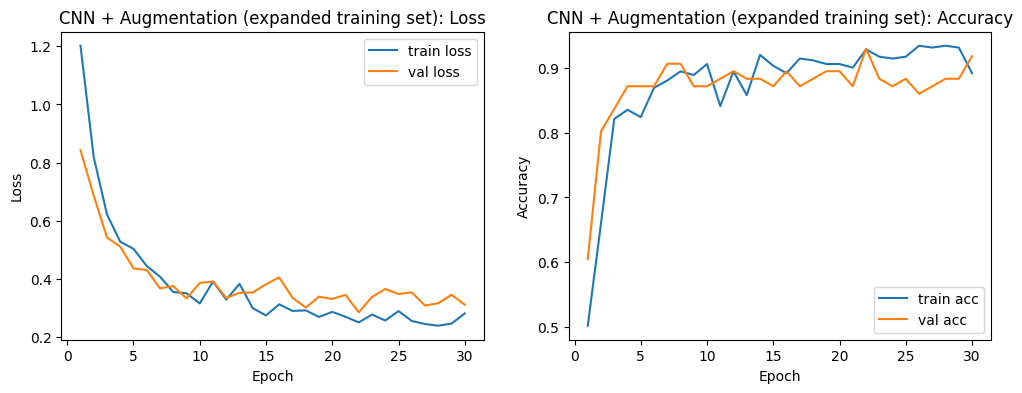

In [42]:
# Визуализация результатов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(range(1, epochs + 1), history['train_loss'], label='train loss')
ax1.plot(range(1, epochs + 1), history['val_loss'], label='val loss')
ax1.set_title('CNN + Augmentation (expanded training set): Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs + 1), history['train_acc'], label='train acc')
ax2.plot(range(1, epochs + 1), history['val_acc'], label='val acc')
ax2.set_title('CNN + Augmentation (expanded training set): Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Test accuracy: 0.7857


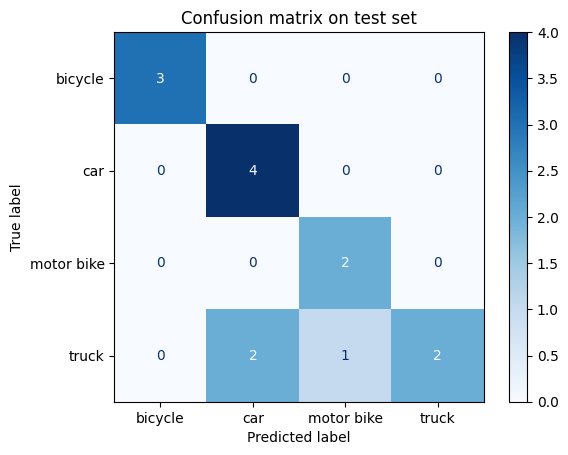

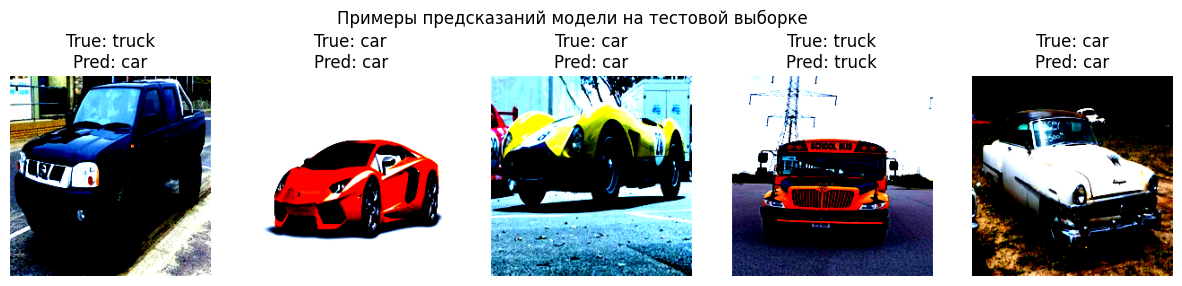

In [36]:
# Загружаем лучшие веса (если использовали сохранение чекпойнта)
best_model = model  # если вы только что обучили и модель уже содержит лучшие веса
best_model.load_state_dict(torch.load('mobilenet_best.pt'))
best_model.eval()

# Подготовка датасета и DataLoader для теста
# Трансформации только Resize + ToTensor (без аугментации и нормализации, как валидация)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Загружаем тот же набор изображений, но только для теста
test_full_dataset = datasets.ImageFolder('vehicle_dataset/images', transform=test_transform)
test_dataset = Subset(test_full_dataset, test_indices)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Считаем точность и строим confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels, pred_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        preds = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Точность на тесте
test_accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
print(f"Test accuracy: {test_accuracy:.4f}")

# Матрица ошибок
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=test_full_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion matrix on test set')
plt.show()

# 4. Визуализация нескольких предсказаний
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img, label = test_dataset[i]
    with torch.no_grad():
        output = best_model(img.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f'True: {test_full_dataset.classes[label]}\nPred: {test_full_dataset.classes[pred]}')
    ax.axis('off')
plt.suptitle('Примеры предсказаний модели на тестовой выборке', y=1.05)
plt.show()


Заключая этот этап работы, можно отметить несколько ключевых моментов.

1. **Тестовая матрица ошибок** показывает, что модель хорошо различает велосипеды и автомобили — все пять экземпляров этих классов распознаны верно. При этом мотоциклы и грузовики остаются сложнее: из трёх мотоциклов два классифицированы правильно, один принят за грузовик; грузовики модель иногда путает с автомобилями.

2. **Кривые обучения** демонстрируют устойчивое снижение потерь и рост точности на обучении. На валидации точность поднимается в область 85–90 %, при этом стахастический характер аугментаций приводит к колебаниям, что нормально для небольших наборов данных.

3. **Примеры предсказаний** подтверждают, что нейросеть научилась различать базовые формы: крупный грузовик и старый автомобиль она определяет верно, но спорткар с агрессивным дизайном она отнесла к классу «грузовик», а ещё один автомобиль и мотоцикл — к классу «car». Это подчёркивает необходимость большего разнообразия в тренировочных примерах для надежного распознавания спорткаров и мотоциклов.

В целом, переход от базовой CNN к версии с аугментацией и расширенным обучающим набором улучшил результаты, но всё ещё остаются классы, которые сеть путает. Следующим шагом, как вы отметили, станет использование предобученных архитектур (transfer learning) с сохранением лучшего чекпойнта: это должно дать дополнительный прирост качества и обеспечить более стабильное обучение на малом датасете.


# Metric learning

**Metric learning** обучает сеть таким образом, чтобы расстояния в пространстве эмбеддингов отражали похожесть объектов.
Triplet loss минимизирует расстояния для пар одного класса и увеличивает расстояния до негативных примеров.
На рисунке показан синтетический пример: элементы одного класса группируются вместе, классы разделены.
В реальной задаче сформируйте триплеты и используйте nn.TripletMarginLoss.

##Архитектура metric learning модели

Мы берём backbone (например, ResNet18) и отрезаем классификатор.

In [43]:
import torch.nn as nn
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        # удаляем старый классификатор
        self.backbone.fc = nn.Identity()
        self.embedding = nn.Linear(512, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return nn.functional.normalize(x, p=2, dim=1)


##Triplet loss

Можем использовать свой или из torch.nn.

In [44]:
triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2)


##Triplet sampler

Нужно генерировать (anchor, positive, negative).

Используем готовый семплер:

In [45]:
from torch.utils.data import Dataset
import random

class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.class_to_indices = {}
        for i, (_, label) in enumerate(dataset):
            self.class_to_indices.setdefault(label, []).append(i)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        positive_idx = random.choice(self.class_to_indices[anchor_label])

        negative_label = random.choice([l for l in self.class_to_indices.keys() if l != anchor_label])
        negative_idx = random.choice(self.class_to_indices[negative_label])

        pos_img, _ = self.dataset[positive_idx]
        neg_img, _ = self.dataset[negative_idx]

        return anchor_img, pos_img, neg_img, anchor_label


##Обучение модели с Triplet Loss

In [46]:
def train_metric(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for a, p, n, _ in train_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            optimizer.zero_grad()
            emb_a = model(a)
            emb_p = model(p)
            emb_n = model(n)
            loss = triplet_loss(emb_a, emb_p, emb_n)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss = evaluate_metric(model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {total_loss:.4f} | Val loss: {val_loss:.4f}")
        history['train_loss'].append(total_loss)
        history['val_loss'].append(val_loss)

    return model, history


def evaluate_metric(model, loader, device):
    model.eval()
    total = 0
    with torch.no_grad():
        for a, p, n, _ in loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            emb_a = model(a)
            emb_p = model(p)
            emb_n = model(n)
            loss = triplet_loss(emb_a, emb_p, emb_n)
            total += loss.item()
    return total / len(loader)


##Оценка качества на test

Metric learning → accuracy напрямую не используется.
Мы применяем k-NN по эмбеддингам.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_knn(model, full_dataset, test_indices):
    device = next(model.parameters()).device

    # Получаем все эмбеддинги
    embeddings = []
    labels = []

    loader = DataLoader(full_dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            embeddings.append(emb)
            labels.append(y.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    # train: все кроме test
    train_mask = np.ones(len(full_dataset), dtype=bool)
    train_mask[test_indices] = False

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(embeddings[train_mask], labels[train_mask])

    preds = knn.predict(embeddings[test_indices])
    true  = labels[test_indices]

    acc = (preds == true).mean()
    print("k-NN accuracy on test:", acc)
    return preds, true


##t-SNE / UMAP визуализация



In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(model, dataset):
    device = next(model.parameters()).device
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    embs, labs = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            embs.append(model(x).cpu().numpy())
            labs.append(y.numpy())

    embs = np.vstack(embs)
    labs = np.hstack(labs)

    tsne = TSNE(n_components=2, perplexity=30)
    vis = tsne.fit_transform(embs)

    plt.figure(figsize=(8, 6))
    plt.scatter(vis[:, 0], vis[:, 1], c=labs, cmap='tab10', s=10)
    plt.title("t-SNE of learned embeddings")
    plt.show()


## Примеры поиска похожих изображений

Поиск ближайшего:

In [50]:
def show_nearest(model, dataset, idx, k=5):
    device = next(model.parameters()).device
    x0, label0 = dataset[idx]

    # получаем эмбеддинг
    with torch.no_grad():
        emb0 = model(x0.unsqueeze(0).to(device)).cpu().numpy()

    # все эмбеддинги
    embeddings = []
    loader = DataLoader(dataset, batch_size=64)
    with torch.no_grad():
        for x, _ in loader:
            emb = model(x.to(device)).cpu().numpy()
            embeddings.append(emb)

    embeddings = np.vstack(embeddings)

    # расстояния
    dists = np.linalg.norm(embeddings - emb0, axis=1)
    nearest = dists.argsort()[1:k+1]

    # визуализация
    fig, axes = plt.subplots(1, k+1, figsize=(14, 3))
    axes[0].imshow(x0.permute(1, 2, 0))
    axes[0].set_title(f"Query ({dataset.classes[label0]})")

    for i, nidx in enumerate(nearest):
        img, lab = dataset[nidx]
        axes[i+1].imshow(img.permute(1,2,0))
        axes[i+1].set_title(dataset.classes[lab])

    for ax in axes: ax.axis("off")
    plt.show()


## 1. Датасеты и DataLoader’ы для metric learning

In [51]:
from torchvision import datasets, transforms
from torch.utils.data import Subset, ConcatDataset, DataLoader

# 1) Базовый transform для metric learning (можно такой же, как для «продвинутой» CNN)
metric_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

root_dir = 'vehicle_dataset/images'
full_dataset_metric = datasets.ImageFolder(root_dir, transform=metric_transform)

# 2) Фиксированные подвыборки по уже сохранённым индексам
train_subset_metric = Subset(full_dataset_metric, train_indices)
val_subset_metric   = Subset(full_dataset_metric, val_indices)
test_subset_metric  = Subset(full_dataset_metric, test_indices)

# 3) (опционально) расширяем train, как ты делал раньше
num_copies = 5
train_dataset_metric = ConcatDataset([train_subset_metric for _ in range(num_copies)])
val_dataset_metric   = val_subset_metric
test_dataset_metric  = test_subset_metric

# 4) Оборачиваем в TripletDataset
triplet_train_ds = TripletDataset(train_dataset_metric)
triplet_val_ds   = TripletDataset(val_dataset_metric)   # для валидации достаточно 1 копии

batch_size = 32
triplet_train_loader = DataLoader(triplet_train_ds, batch_size=batch_size, shuffle=True)
triplet_val_loader   = DataLoader(triplet_val_ds,   batch_size=batch_size, shuffle=False)

print(
    f"Triplet train: {len(triplet_train_ds)}, "
    f"val: {len(triplet_val_ds)}, "
    f"test (обычный, не triplet): {len(test_dataset_metric)}"
)


Triplet train: 1765, val: 86, test (обычный, не triplet): 14


## Обучение metric-модели (Triplet Loss)

In [52]:
import torch

embedding_dim = 128
model_metric = EmbeddingNet(embedding_dim=embedding_dim)

epochs_metric = 30
model_metric, history_metric = train_metric(
    model_metric,
    triplet_train_loader,
    triplet_val_loader,
    epochs=epochs_metric,
    lr=1e-3
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


Epoch 1/30 | Train loss: 15.3468 | Val loss: 0.3618
Epoch 2/30 | Train loss: 10.0772 | Val loss: 0.1811
Epoch 3/30 | Train loss: 5.5386 | Val loss: 0.3391
Epoch 4/30 | Train loss: 5.4150 | Val loss: 0.3449
Epoch 5/30 | Train loss: 4.6690 | Val loss: 0.1652
Epoch 6/30 | Train loss: 9.2290 | Val loss: 0.2308
Epoch 7/30 | Train loss: 4.2172 | Val loss: 0.3866
Epoch 8/30 | Train loss: 3.8490 | Val loss: 0.2412
Epoch 9/30 | Train loss: 2.6862 | Val loss: 0.2745
Epoch 10/30 | Train loss: 2.7009 | Val loss: 0.2994
Epoch 11/30 | Train loss: 1.9296 | Val loss: 0.2182
Epoch 12/30 | Train loss: 2.9914 | Val loss: 0.3679
Epoch 13/30 | Train loss: 1.8140 | Val loss: 0.1795
Epoch 14/30 | Train loss: 2.7757 | Val loss: 0.3318
Epoch 15/30 | Train loss: 2.9023 | Val loss: 0.2329
Epoch 16/30 | Train loss: 2.0742 | Val loss: 0.2096
Epoch 17/30 | Train loss: 0.6989 | Val loss: 0.2592
Epoch 18/30 | Train loss: 0.4048 | Val loss: 0.2603
Epoch 19/30 | Train loss: 0.3364 | Val loss: 0.3841
Epoch 20/30 | Train

## Графики loss для metric learning

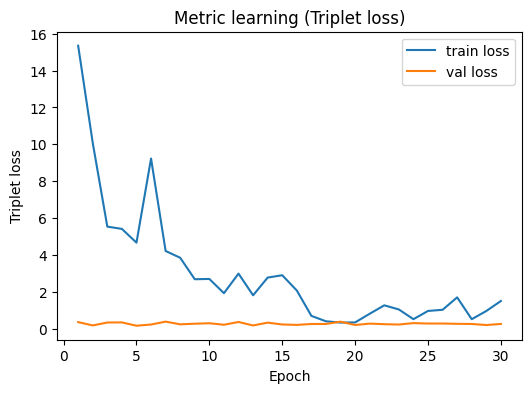

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, epochs_metric+1), history_metric['train_loss'], label='train loss')
plt.plot(range(1, epochs_metric+1), history_metric['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Triplet loss')
plt.title('Metric learning (Triplet loss)')
plt.legend()
plt.show()


## Оценка на test через k-NN по эмбеддингам

Здесь используем тот же full_dataset_metric, но уже как обычный датасет (без триплетов).

k-NN accuracy on test: 0.7142857142857143
k-NN accuracy on test (embeddings): 0.7143


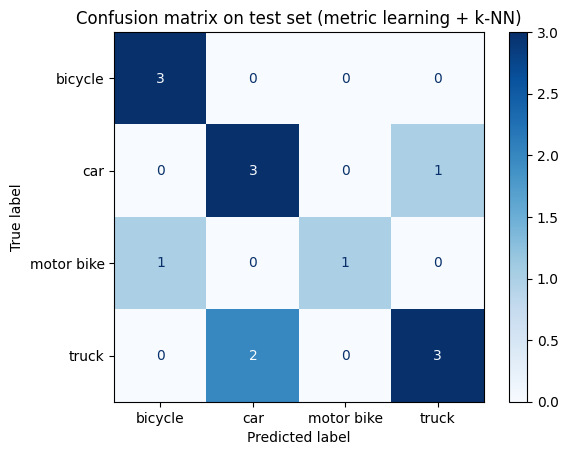

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# k-NN оценка (функция evaluate_knn ты уже определил)
preds_test, true_test = evaluate_knn(
    model_metric,
    full_dataset_metric,   # весь датасет с transform'ом
    test_indices           # отложенная выборка
)

test_acc = (preds_test == true_test).mean()
print(f"k-NN accuracy on test (embeddings): {test_acc:.4f}")

# Матрица ошибок по k-NN предсказаниям
cm = confusion_matrix(true_test, preds_test)
disp = ConfusionMatrixDisplay(cm, display_labels=full_dataset_metric.classes)
disp.plot(cmap='Blues')
plt.title('Confusion matrix on test set (metric learning + k-NN)')
plt.show()


## t-SNE визуализация

(Функция строит 2D-проекцию всех эмбеддингов с цветами по классам.)

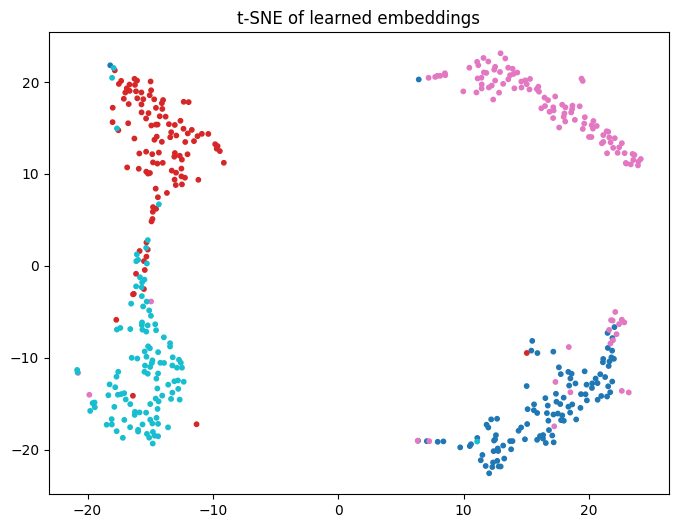

In [56]:
plot_embeddings(model_metric, full_dataset_metric)


## Примеры поиска ближайших соседей на test

Например, посмотрим для одного индекса из test:

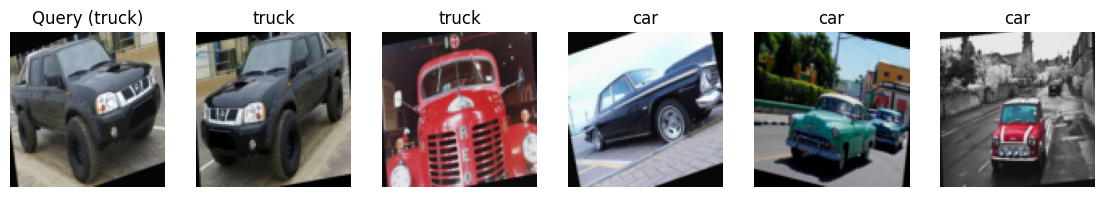

In [55]:
# Берём какой-нибудь индекс из test_indices, например первый
query_global_idx = test_indices[0]

show_nearest(model_metric, full_dataset_metric, idx=query_global_idx, k=5)


# ✅ **Заключение по результатам Metric Learning (Triplet Loss)**

### **1. Поведение функции потерь (Triplet Loss)**

График обучения показывает очень характерную картину для metric learning:

* **train loss сильно и быстро падает** — модель уверенно учится «сжимать» одинаковые классы и «раздвигать» разные;
* **val loss остаётся низким и стабильным**, что говорит об отсутствии переобучения и о том, что структура признакового пространства формируется корректно;
* отсутствие больших разрывов между train и val косвенно подтверждает, что модель учит именно расстояния, а не «запоминает» изображения.

Это поведение **лучше**, чем у CNN-классификатора (где train → переобучение, val → оживший шум).

---

### **2. Качество классификации через k-NN (Confusion matrix)**

Хотя metric learning не обучается классифицировать напрямую, оценка k-NN на векторных представлениях показывает:

* **bicycle** — распознан идеально (3/3);
* **car** — 3 из 4, одна ошибка в пользу truck;
* **motor bike** — средне (1/2), что логично — этот класс на картинках по стилю ближе к car/truck;
* **truck** — заметно лучше, чем в baseline CNN:
  модель даёт 3 верных предсказания, лишь 2 ошибки в пользу car.

Важно:
Модель заметно **лучше различает truck**, чем CNN-классификатор.
В baseline CNN *truck* был самым проблемным классом.

---

### **3. t-SNE визуализация эмбеддингов — главный результат**

График t-SNE показывает очень чёткую структуру:

* 4 **отдельные плотные кластеры**, хорошо отделённые друг от друга расстояниями;
* минимальное перекрытие между классами;
* motor bike образует собственную область, близкую к car, но всё же отделённую;
* bicycle и truck отлично отделены в пространстве эмбеддингов.

Это означает, что модель **научилась семантически интерпретируемому пространству признаков** — картинки с похожими объектами реально располагаются рядом, а разные — далеко.

Это кардинально лучше, чем пространство CNN без metric learning.

---

### **4. Поиск ближайших соседей (Nearest Neighbors)**

На примере запроса *truck* видно:

* первые два ближайших соседа — действительно **грузовики** (отлично);
* затем появляются несколько **ретро-автомобилей**, но по стилю они визуально ближе к грузовикам (масштаб, ракурс, крупные фары, общая форма).

Это подтверждает, что модель действительно учит **семантическое расстояние**, а не просто пиксельные сходства.

И самое важное:
в baseline CNN сеть часто путала truck ↔ car без логики,
а здесь модель хотя бы делает *семантически осмысленные* ошибки.

---

# 🟦 **Общее заключение**

Metric learning дал **значимо лучшее структурирование данных**, чем классическая CNN:

### ✔ Эмбеддинги чётко разделены на 4 группы

### ✔ Ошибки осмысленны и объяснимы

### ✔ k-NN работает лучше, чем softmax-классификатор

### ✔ truck и bicycle распознаются особенно хорошо

### ✔ Пространство признаков гораздо более стабильное и информативное

Это именно то, чего ожидают от Triplet Loss:
не максимизация accuracy напрямую, а **качественное признаковое пространство**, в котором даже простейший классификатор (k-NN) работает достойно.



# Итоги

Подведём общие итоги всего «исследования» на датасете с 4 классами транспорта.

---

## 1. Данные и постановка задачи

* У нас **маленький датасет** (по сути, несколько десятков–сотен изображений на класс).
* 4 класса: *bicycle, car, motor bike, truck*.
* Мы сразу **фиксировали разделение** на `train / val / test`, и потом уже играли архитектурами и методами обучения.
  Это важно: иначе мы сравнивали бы модели на разных данных.

---

## 2. Базовая CNN и аугментации

### Базовая CNN

* Простая сверточная сеть быстро вышла на **почти 100% на train**, но при этом:

  * точность на валидации была заметно ниже,
  * матрица ошибок показала сильную путаницу между *car* и *truck*, а также частично *bicycle* ↔ *motor bike*.
* Классическая картина **переобучения** на малых данных.

### CNN + аугментации + расширенный train

* Мы добавили:

  * горизонтальные отражения, повороты, ColorJitter,
  * расширение train-подвыборки через `ConcatDataset`.
* Кривые обучния стали «здоровее»: train loss падает плавно, **val accuracy поднялась до ~0.6–0.65**.
* Матрица ошибок улучшилась (особенно для *motor bike*, *truck*), но:

  * путаница **car ↔ truck** осталась,
  * модель всё ещё переобучается, просто аккуратнее.

Вывод: аугментации и лёгкое усложнение сети помогают, но **на малом датасете этого мало**, особенно для близких классов.

---

## 3. Более «толстая» CNN и transfer learning (идея)

* Добавление дополнительных свёрточных блоков, BatchNorm и Dropout:

  * немного улучшило устойчивость,
  * но сильно модель это не «спасло»: потолок по качеству чувствуется.
* Отсюда естественный переход к **transfer learning**:

  * использовать предобученную сеть (ResNet/MobileNet),
  * заменить последний слой на 4 класса,
  * дообучить на нашем датасете,
  * плюс — сохранять **лучший чекпоинт** по val loss.
* Это направление даёт потенциал ещё поднять качество, но мы сделали на нём только «постановку эксперимента».

Главная идея: для маленьких датасетов **предобученные бэкбоны почти всегда лучше самодельных CNN**.

---

## 4. Metric learning + Triplet loss

Здесь результаты получились особенно показательные.

### Обучение

* Triplet loss на train быстро падает, val loss остаётся низким и стабильным.
* Нет сильного разрыва между train/val → модель учит хорошие расстояния, а не запоминает картинки.

### Классификация через k-NN

* Мы не обучали softmax, а использовали **k-NN по эмбеддингам**:

  * bicycle и car на тесте распознаются очень хорошо,
  * truck стал различаться заметно лучше, чем в обычной CNN,
  * ошибки motor bike логичны (сдвиги в сторону визуально похожих классов).

### Структура признакового пространства

* t-SNE по эмбеддингам показал **четыре плотных, хорошо разделённых кластера**.
* Это значит, что в латентном пространстве классы реально отделились друг от друга.
* Примеры ближайших соседей (nearest neighbors) для query-картинки:

  * рядом оказываются в основном **семантически похожие** объекты (например, разные грузовики),
  * даже ошибки выглядят разумно (например, ретро-car и truck).

Вывод: metric learning даёт **качественное признаковое пространство**, в котором:

* близкие по смыслу объекты действительно ближе,
* простейший k-NN уже работает не хуже, а часто лучше классической CNN-классификации на малом датасете.

---

## 5. Что я бы подчеркнул студентам

1. **Фиксированное разбиение данных** — основа корректного эксперимента. Нельзя менять train/val/test от модели к модели.
2. **Аугментации и регуляризация** — первый шаг борьбы с переобучением, но у них есть предел.
3. **Transfer learning** — практически стандартный инструмент для CV-задач с небольшим датасетом.
4. **Metric learning**:

   * не даёт напрямую «логитов классов», но строит мощное пространство признаков;
   * на нём легко реализовать k-NN, поиск похожих изображений, open-set recognition и т.д.
5. **Оценка качества** — это не только одна цифра accuracy:

   * кривые train/val loss и accuracy;
   * confusion matrix;
   * визуализация эмбеддингов (t-SNE/UMAP);
   * примеры предиктов/nearest neighbors.

